# First analysis notebook

In [8]:
import torch.nn.functional as F
from torch import Tensor
import torch 
from transformers import AutoTokenizer, AutoModel
from scipy.spatial.distance import cosine
import pandas as pd
import sys, json, math, os
import numpy as np
print('First imports complete.')

def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-base")
model = AutoModel.from_pretrained("thenlper/gte-base")
model.eval()
model.to(device)

print('Tokenizer and model built.')

import nltk

nltk.download('punkt')

from nltk.tokenize import sent_tokenize

print('NLTK downloaded.')

First imports complete.
Using cpu
Tokenizer and model built.
NLTK downloaded.


[nltk_data] Downloading package punkt to /Users/tunder/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
sources = {'10444_Turbo-3-0.tsv': 0, '10444_Turbo-4-0.5.tsv': 0.5, '10444_Turbo-5-1.0.tsv': 1.0}

dataframe_list = []

for filename, temp in sources.items():
    in_df = pd.read_csv(filename, sep = '\t')
    in_df = in_df.loc[ : , ['mode', 'text', 'chunkindex']]
    in_df['temperature'] = temp
    dataframe_list.append(in_df)

data = pd.concat(dataframe_list, axis = 0)
data.shape

(285, 4)

In [8]:
prediction_sentences = dict()
summary_sentences = dict()

maxchunk = max(data['chunkindex'])

for i in range(1, maxchunk + 1):
    predict_text = ' '.join(data.loc[(data['chunkindex'] == i) & (data['mode'] == 'prediction'), 'text'].values)
    summary_text = ' '.join(data.loc[(data['chunkindex'] == i) & (data['mode'] == 'summary'), 'text'].values)
    
    prediction_sentences[i] = list(sent_tokenize(predict_text))
    summary_sentences[i] = list(sent_tokenize(summary_text))

In [11]:
summary_sentences[6]

["The narrator and Merle witness Kerrin's outburst and accidental injury to their dog Cale, causing their mother to take Cale outside and confront their father.",
 "The narrator and Merle are left feeling sad and uncertain about Kerrin's whereabouts.",
 'Kerrin accidentally slashes their dog, Cale, causing chaos and anger in the room.',
 "Kerrin's mother rushes out in a black rage, and their father believes Kerrin killed the dog.",
 'Kerrin accidentally slashes their blind dog, causing chaos and anger in the room.',
 'Their mother storms out in a rage, while the narrator and their sibling, Merle, are left behind feeling shocked and saddened.']

In [19]:
summary_embeddings = dict()
prediction_embeddings = dict()

with torch.no_grad():   # save memory
    for i in range(1, maxchunk + 1):
        # Tokenize and move to device
        batch_dict = tokenizer(summary_sentences[i], max_length=512, padding=True, truncation=True, return_tensors='pt')
        batch_dict = {k: v.to(device) for k, v in batch_dict.items()}

        # Generate embeddings
        outputs = model(**batch_dict)
        raw_embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
        embeddings = F.normalize(raw_embeddings, p=2, dim=1)

        # Append to master list
        summary_embeddings[i] = embeddings
        print(i)
        
        # Tokenize and move to device
        batch_dict = tokenizer(prediction_sentences[i], max_length=512, padding=True, truncation=True, return_tensors='pt')
        batch_dict = {k: v.to(device) for k, v in batch_dict.items()}

        # Generate embeddings
        outputs = model(**batch_dict)
        raw_embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
        embeddings = F.normalize(raw_embeddings, p=2, dim=1)

        # Append to master list
        prediction_embeddings[i] = embeddings

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [18]:
cosine(summary_embeddings[18][1], summary_embeddings[21][2])

0.15727925300598145

In [20]:
import numpy as np

def avg_cosine(a, b):
    the_cosines = []
    for embed_a in a:
        for embed_b in b:
            the_cosines.append(cosine(embed_a, embed_b))
    return np.mean(the_cosines)

distance = np.zeros((maxchunk, maxchunk), dtype=float)
for i in range(1, maxchunk +1):
    for j in range(1, maxchunk + 1):
        distance[i-1, j-1] = avg_cosine(prediction_embeddings[i], summary_embeddings[j])

In [21]:
import seaborn as sns

<AxesSubplot:>

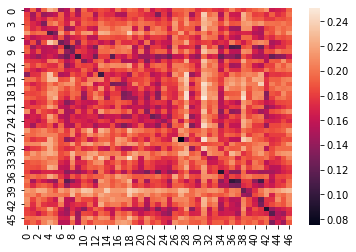

In [22]:
sns.heatmap(distance)

In [23]:
samechunk = []
for i in range(maxchunk):
    samechunk.append(distance[i, i])

<AxesSubplot:xlabel='x', ylabel='y'>

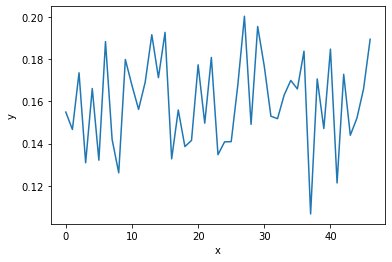

In [30]:
plot_df = pd.DataFrame({'x': [a for a in range(maxchunk)], 'y' : samechunk})

sns.lineplot(data = plot_df, x = 'x', y = 'y')

In [74]:
def avg_cosine(a, b):
    the_cosines = []
    for embed_a in a:
        for embed_b in b:
            the_cosines.append(cosine(embed_a, embed_b))
    return np.mean(the_cosines)

def bottom_half_cosines(a, b, c):
    the_cosines = []
    for embed_a in a:
        for embed_b in b:
            the_cosines.append(cosine(embed_a, embed_b))
        for embed_c in c:
            the_cosines.append(cosine(embed_a, embed_c))
    the_cosines.sort()
    number_to_take = math.ceil(len(the_cosines) * .4)
    return np.mean(the_cosines[0 : number_to_take])

def get_distance(sources):    
    dataframe_list = []

    for filename, temp in sources.items():
        in_df = pd.read_csv(filename, sep = '\t')
        in_df = in_df.loc[ : , ['mode', 'text', 'chunkindex']]
        in_df['temperature'] = temp
        dataframe_list.append(in_df)

    data = pd.concat(dataframe_list, axis = 0)
    data.shape
    
    prediction_sentences = dict()
    summary_sentences = dict()

    maxchunk = max(data['chunkindex'])

    for i in range(1, maxchunk + 1):
        predict_text = ' '.join(data.loc[(data['chunkindex'] == i) & (data['mode'] == 'prediction'), 'text'].values)
        summary_text = ' '.join(data.loc[(data['chunkindex'] == i) & (data['mode'] == 'summary'), 'text'].values)

        prediction_sentences[i] = list(sent_tokenize(predict_text))
        summary_sentences[i] = list(sent_tokenize(summary_text))
    
    summary_embeddings = dict()
    prediction_embeddings = dict()

    with torch.no_grad():   # save memory
        for i in range(1, maxchunk + 1):
            # Tokenize and move to device
            batch_dict = tokenizer(summary_sentences[i], max_length=512, padding=True, truncation=True, return_tensors='pt')
            batch_dict = {k: v.to(device) for k, v in batch_dict.items()}

            # Generate embeddings
            outputs = model(**batch_dict)
            raw_embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
            embeddings = F.normalize(raw_embeddings, p=2, dim=1)

            # Append to master list
            summary_embeddings[i] = embeddings
            if i%10 == 1:
                print(i)

            # Tokenize and move to device
            batch_dict = tokenizer(prediction_sentences[i], max_length=512, padding=True, truncation=True, return_tensors='pt')
            batch_dict = {k: v.to(device) for k, v in batch_dict.items()}

            # Generate embeddings
            outputs = model(**batch_dict)
            raw_embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
            embeddings = F.normalize(raw_embeddings, p=2, dim=1)

            # Append to master list
            prediction_embeddings[i] = embeddings
            
    distance = np.zeros((maxchunk, maxchunk), dtype=float)
    for i in range(1, maxchunk +1):
        for j in range(1, maxchunk + 1):
            if j < maxchunk:
                future_embeddings = summary_embeddings[j + 1]
            else:
                future_embeddings = summary_embeddings[j]
                
            distance[i-1, j-1] = bottom_half_cosines(prediction_embeddings[i], summary_embeddings[j], future_embeddings)
    
    samechunk = []
    for i in range(maxchunk):
        samechunk.append(distance[i, i])
        
    return maxchunk, distance, samechunk

In [80]:
clocksources = {'out/25340_Turbo-0.tsv': 0, 'out/25340_Turbo-0.5.tsv': 0.5, 'out/25340_Turbo-1.0.tsv': 1.0}
clockmax, clockdist, clocksame = get_distance(clocksources)

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211


0.12853717660884817 0.11925574103399869 0.13582187813364885 0.11367860495300224


<AxesSubplot:xlabel='x', ylabel='y'>

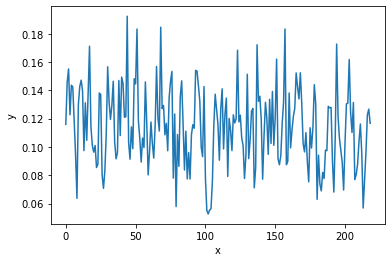

In [81]:
print(np.mean(ysame), np.mean(oilsame), np.mean(neurosame), np.mean(clocksame))
plot_df = pd.DataFrame({'x': [a for a in range(clockmax)], 'y' : clocksame})
sns.lineplot(data = plot_df, x = 'x', y = 'y')

In [82]:
corpsesources = {'out/10785_Turbo-0.tsv': 0, 'out/10785_Turbo-0.5.tsv': 0.5, 'out/10785_Turbo-1.0.tsv': 1.0}
corpmax, corpdist, corpsame = get_distance(corpsesources)

1
11
21
31
41
51


0.11626481671210771 0.12853717660884817 0.11925574103399869 0.13582187813364885


<AxesSubplot:xlabel='x', ylabel='y'>

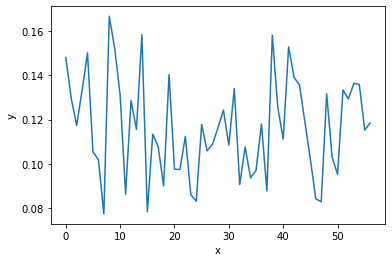

In [83]:
print(np.mean(corpsame), np.mean(ysame), np.mean(oilsame), np.mean(neurosame))
plot_df = pd.DataFrame({'x': [a for a in range(corpmax)], 'y' : corpsame})
sns.lineplot(data = plot_df, x = 'x', y = 'y')

In [100]:
jedisources = {'out/22085_Turbo-0.tsv': 0, 'out/22085_Turbo-0.5.tsv': 0.5, 'out/22085_Turbo-1.0.tsv': 1.0}
jedimax, jedidist, jedisame = get_distance(jedisources)

1
11
21
31
41
51


0.11162613132746282 0.1335897106020396 0.10127674323479324 0.11626481671210771 0.12853717660884817 0.11925574103399869 0.13582187813364885


<AxesSubplot:xlabel='x', ylabel='y'>

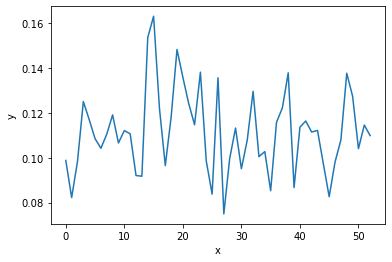

In [101]:
print(np.mean(jedisame), np.mean(bsame), np.mean(zsame), np.mean(corpsame), np.mean(ysame), np.mean(oilsame), np.mean(neurosame))
plot_df = pd.DataFrame({'x': [a for a in range(jedimax)], 'y' : jedisame})
sns.lineplot(data = plot_df, x = 'x', y = 'y')

In [104]:
ambsources = {'out/10764_Turbo-0.tsv': 0, 'out/10764_Turbo-0.5.tsv': 0.5, 'out/10764_Turbo-1.0.tsv': 1.0}
ambmax, ambdist, ambsame = get_distance(ambsources)

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341


0.11916675362328705 0.11162613132746282 0.1335897106020396 0.10127674323479324 0.11626481671210771 0.12853717660884817 0.11925574103399869 0.13582187813364885


<AxesSubplot:xlabel='x', ylabel='y'>

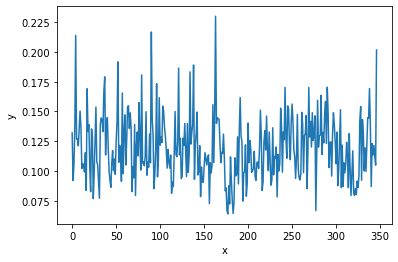

In [105]:
print(np.mean(ambsame), np.mean(jedisame), np.mean(bsame), np.mean(zsame), np.mean(corpsame), np.mean(ysame), np.mean(oilsame), np.mean(neurosame))
plot_df = pd.DataFrame({'x': [a for a in range(ambmax)], 'y' : ambsame})
sns.lineplot(data = plot_df, x = 'x', y = 'y')

In [111]:
bridesources = {'out/10664_Turbo-0.tsv': 0, 'out/10664_Turbo-0.5.tsv': 0.5, 'out/10664_Turbo-1.0.tsv': 1.0}
bridemax, bridedist, bridesame = get_distance(bridesources)

1
11
21
31
41
51
61


In [134]:
google = np.log(np.array([5, 1, 52, 17, 1, 5, 1200, 0, 30, 0]) + 1)

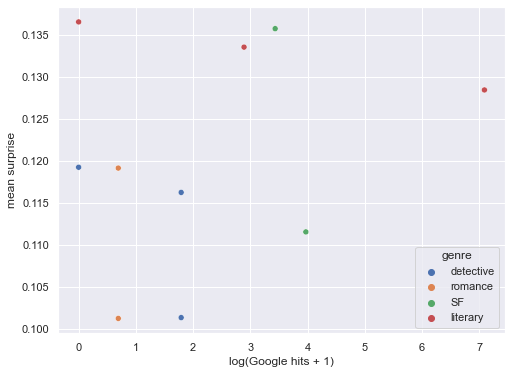

In [143]:
plotdf = pd.DataFrame({'mean surprise': [0.1014, 0.1192, 0.1116, 0.1336, 0.1013, .1163, 0.1285, 0.1193, 0.1358, 0.1366],
                      'log(Google hits + 1)': google,
                      'genre': ['detective', 'romance', 'SF', 'literary', 'romance', 'detective', 'literary', 'detective', 'SF', 'literary']})
sns.scatterplot(data = plotdf, y = 'mean surprise', x = 'log(Google hits + 1)', hue = 'genre')
plt.show()

In [141]:
pearsonr(google, [0.1014, 0.1192, 0.1116, 0.1336, 0.1013, .1163, 0.1285, 0.1193, 0.1358, 0.1366])

(0.22595927385040449, 0.5301874103284557)

0.10144201817071441 0.11916675362328705 0.11162613132746282 0.1335897106020396 0.10127674323479324 0.11626481671210771 0.12853717660884817 0.11925574103399869 0.13582187813364885


<AxesSubplot:xlabel='x', ylabel='y'>

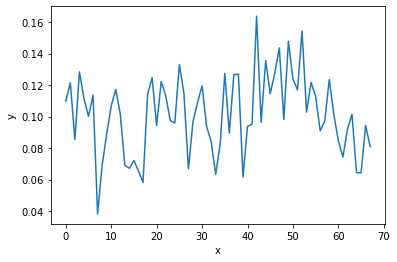

In [112]:
print(np.mean(bridesame), np.mean(ambsame), np.mean(jedisame), np.mean(bsame), np.mean(zsame), np.mean(corpsame), np.mean(ysame), np.mean(oilsame), np.mean(neurosame))
plot_df = pd.DataFrame({'x': [a for a in range(bridemax)], 'y' : bridesame})
sns.lineplot(data = plot_df, x = 'x', y = 'y')

In [97]:
bsources = {'out/22741_Turbo-0.tsv': 0, 'out/22741_Turbo-0.5.tsv': 0.5, 'out/22741_Turbo-1.0.tsv': 1.0}
bmax, bdist, bsame = get_distance(bsources)

1
11
21
31
41
51
61
71
81
91


In [89]:
zsources = {'out/22982_Turbo-0.tsv': 0, 'out/22982_Turbo-0.5.tsv': 0.5, 'out/22982_Turbo-1.0.tsv': 1.0}
zmax, zdist, zsame = get_distance(zsources)

1
11
21
31
41
51
61
71
81
91
101
111
121
131


0.1335897106020396 0.10127674323479324 0.11626481671210771 0.12853717660884817 0.11925574103399869 0.13582187813364885


<AxesSubplot:xlabel='x', ylabel='y'>

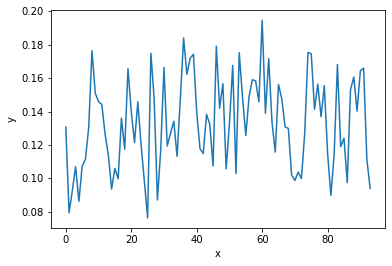

In [98]:
print(np.mean(bsame), np.mean(zsame), np.mean(corpsame), np.mean(ysame), np.mean(oilsame), np.mean(neurosame))
plot_df = pd.DataFrame({'x': [a for a in range(bmax)], 'y' : bsame})
sns.lineplot(data = plot_df, x = 'x', y = 'y')

0.10127674323479324 0.11626481671210771 0.12853717660884817 0.11925574103399869 0.13582187813364885


<AxesSubplot:xlabel='x', ylabel='y'>

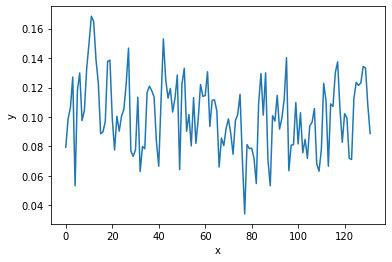

In [90]:
print(np.mean(zsame), np.mean(corpsame), np.mean(ysame), np.mean(oilsame), np.mean(neurosame))
plot_df = pd.DataFrame({'x': [a for a in range(zmax)], 'y' : zsame})
sns.lineplot(data = plot_df, x = 'x', y = 'y')

In [76]:
youngsources = {'out/4880_Turbo-0.tsv': 0, 'out/4880_Turbo-0.5.tsv': 0.5, 'out/4880_Turbo-1.0.tsv': 1.0}
ymax, ydist, ysame = get_distance(youngsources)

1
11
21
31
41
51
61
71
81


0.12853717660884817 0.11925574103399869 0.13582187813364885


<AxesSubplot:xlabel='x', ylabel='y'>

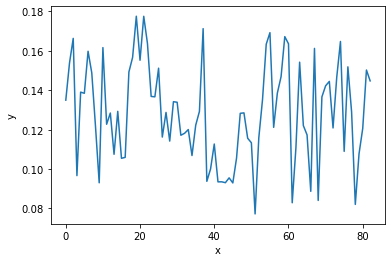

In [79]:
print(np.mean(ysame), np.mean(oilsame), np.mean(neurosame))
plot_df = pd.DataFrame({'x': [a for a in range(ymax)], 'y' : ysame})
sns.lineplot(data = plot_df, x = 'x', y = 'y')

In [21]:
neurosources = {'22193_Turbo-5.tsv': 0, '22193_Turbo-6-0.5.tsv': 0.5, '22193_Turbo-7-1.0.tsv': 1.0}
neuromax, neurodist, neurosame = get_distance(neurosources)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78


<AxesSubplot:xlabel='x', ylabel='y'>

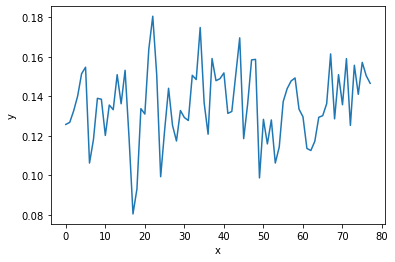

In [22]:
import seaborn as sns

plot_df = pd.DataFrame({'x': [a for a in range(neuromax)], 'y' : neurosame})
sns.lineplot(data = plot_df, x = 'x', y = 'y')

In [72]:
oilsources = {'10944_Turbo-0.tsv': 0, '10944_Turbo-0.5.tsv': 0.5, '10944_Turbo-1.0.tsv': 1.0}
oilmax, oildist, oilsame = get_distance(oilsources)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


<AxesSubplot:xlabel='x', ylabel='y'>

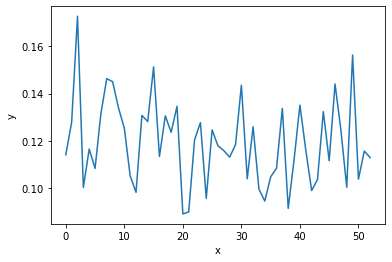

In [73]:
plot_df = pd.DataFrame({'x': [a for a in range(oilmax)], 'y' : oilsame})
sns.lineplot(data = plot_df, x = 'x', y = 'y')

In [23]:
np.mean(neurosame)

0.13582187813364885

In [59]:
from scipy.stats import tstd

In [60]:
tstd(neurosame)

0.018734354235019447

<AxesSubplot:>

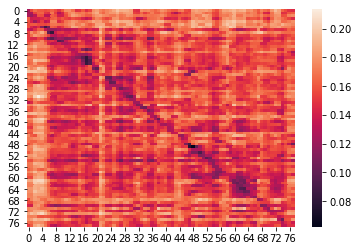

In [24]:
sns.heatmap(neurodist)

In [49]:
def human_comparison(sources, human_source):    
    dataframe_list = []

    for filename, temp in sources.items():
        in_df = pd.read_csv(filename, sep = '\t')
        in_df = in_df.loc[ : , ['mode', 'text', 'chunkindex']]
        in_df['temperature'] = temp
        dataframe_list.append(in_df)

    data = pd.concat(dataframe_list, axis = 0)
    data.shape
    
    prediction_sentences = dict()
    summary_sentences = dict()

    maxchunk = max(data['chunkindex'])

    for i in range(1, maxchunk + 1):
        predict_text = ' '.join(data.loc[(data['chunkindex'] == i) & (data['mode'] == 'prediction'), 'text'].values)
        summary_text = ' '.join(data.loc[(data['chunkindex'] == i) & (data['mode'] == 'summary'), 'text'].values)

        prediction_sentences[i] = list(sent_tokenize(predict_text))
        summary_sentences[i] = list(sent_tokenize(summary_text))
    
    human_df = pd.read_csv(human_source, sep = '\t')
    human_prediction_sents = dict()
    for idx, row in human_df.iterrows():
        chunkidx = int(row['chunkindex'])
        if row['mode'] != 'prediction':
            continue
        human_prediction_sents[chunkidx] = list(sent_tokenize(row['text']))
        print(chunkidx)
    
    summary_embeddings = dict()
    prediction_embeddings = dict()
    human_embeddings = dict()

    with torch.no_grad():   # save memory
        for i in range(1, maxchunk + 1):
            #if i not in human_prediction_sents:
                #continue
            # Tokenize and move to device
            batch_dict = tokenizer(summary_sentences[i], max_length=512, padding=True, truncation=True, return_tensors='pt')
            batch_dict = {k: v.to(device) for k, v in batch_dict.items()}

            # Generate embeddings
            outputs = model(**batch_dict)
            raw_embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
            embeddings = F.normalize(raw_embeddings, p=2, dim=1)

            # Append to master list
            summary_embeddings[i] = embeddings
            print(i)

            # Tokenize and move to device
            batch_dict = tokenizer(prediction_sentences[i], max_length=512, padding=True, truncation=True, return_tensors='pt')
            batch_dict = {k: v.to(device) for k, v in batch_dict.items()}

            # Generate embeddings
            outputs = model(**batch_dict)
            raw_embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
            embeddings = F.normalize(raw_embeddings, p=2, dim=1)

            # Append to master list
            prediction_embeddings[i] = embeddings
            
            if i in human_prediction_sents:
                batch_dict = tokenizer(human_prediction_sents[i], max_length=512, padding=True, truncation=True, return_tensors='pt')
                batch_dict = {k: v.to(device) for k, v in batch_dict.items()}

                # Generate embeddings
                outputs = model(**batch_dict)
                raw_embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
                embeddings = F.normalize(raw_embeddings, p=2, dim=1)

                # Append to master list
                human_embeddings[i] = embeddings
                     
    auto_distance = []
    human_distance = []
    for i in range(1, maxchunk +1):
        if i < maxchunk:
            future_embeddings = summary_embeddings[i + 1]
        else:
            future_embeddings = summary_embeddings[i]
            
        if i in human_embeddings:
            auto_distance.append(bottom_half_cosines(prediction_embeddings[i], summary_embeddings[i], future_embeddings))
            human_distance.append(bottom_half_cosines(human_embeddings[i], summary_embeddings[i], future_embeddings))

    return auto_distance, human_distance, human_embeddings, prediction_embeddings, summary_embeddings

In [50]:
auto_distance, human_distance, human_embeddings, prediction_embeddings, summary_embeddings =\
human_comparison({'10444_Turbo-3-0.tsv': 0, '10444_Turbo-4-0.5.tsv': 0.5, '10444_Turbo-5-1.0.tsv': 1.0},
                '10444_WEU-1.tsv')

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [51]:
from scipy.stats import pearsonr
pearsonr(auto_distance, human_distance)

(0.16992145317382226, 0.4273112733961003)

In [53]:
np.mean(auto_distance)

0.13660608675199518

In [54]:
np.mean(human_distance)

0.1539047477086858

In [42]:
from matplotlib import pyplot as plt

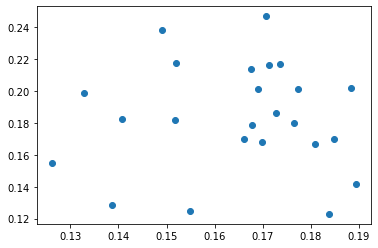

In [46]:
plt.scatter(auto_distance, human_distance)

In [62]:
auto_distance2, human_distance2, human_embeddings2, prediction_embeddings2, summary_embeddings2 =\
human_comparison({'10944_Turbo-0.tsv': 0, '10944_Turbo-0.5.tsv': 0.5, '10944_Turbo-1.0.tsv': 1.0},
                '10944_WEU.tsv')

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49
51
53
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


In [63]:
pearsonr(auto_distance2, human_distance2)

(0.3086885364459568, 0.11720038029380145)

In [65]:
autodist = auto_distance + auto_distance2
len(autodist)

51

In [66]:
humdist = human_distance + human_distance2
len(humdist)

51

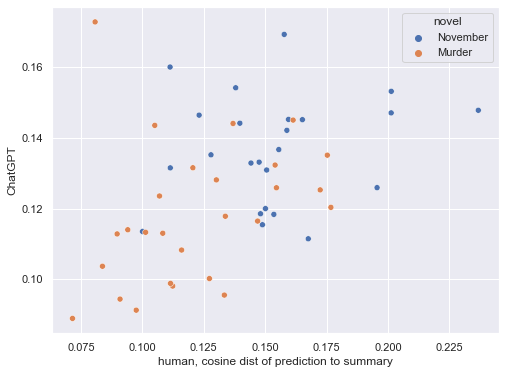

In [120]:
color = ["November"] * len(auto_distance)
color = color + ["Murder"] * len(auto_distance2)
plotdf = pd.DataFrame({'human, cosine dist of prediction to summary': humdist, 'ChatGPT': autodist, 'novel': color})
sns.set(rc={'figure.figsize':(8,6)})
sns.scatterplot(data = plotdf, x = 'human, cosine dist of prediction to summary', y = 'ChatGPT', hue = 'novel')
plt.show()

In [67]:
pearsonr(autodist, humdist)

(0.4114572641188322, 0.0027029916708072453)

In [68]:
np.mean(auto_distance2)

0.11831215708989685

In [126]:
def make_fraction(vector):
    fraction = []
    veclen = len(vector)
    for idx, v in enumerate(vector):
        fraction.append(int((idx/veclen) * 1000))
    return fraction

In [127]:
make_fraction(neurosame) + make_fraction(zsame)

[0,
 12,
 25,
 38,
 51,
 64,
 76,
 89,
 102,
 115,
 128,
 141,
 153,
 166,
 179,
 192,
 205,
 217,
 230,
 243,
 256,
 269,
 282,
 294,
 307,
 320,
 333,
 346,
 358,
 371,
 384,
 397,
 410,
 423,
 435,
 448,
 461,
 474,
 487,
 500,
 512,
 525,
 538,
 551,
 564,
 576,
 589,
 602,
 615,
 628,
 641,
 653,
 666,
 679,
 692,
 705,
 717,
 730,
 743,
 756,
 769,
 782,
 794,
 807,
 820,
 833,
 846,
 858,
 871,
 884,
 897,
 910,
 923,
 935,
 948,
 961,
 974,
 987,
 0,
 7,
 15,
 22,
 30,
 37,
 45,
 53,
 60,
 68,
 75,
 83,
 90,
 98,
 106,
 113,
 121,
 128,
 136,
 143,
 151,
 159,
 166,
 174,
 181,
 189,
 196,
 204,
 212,
 219,
 227,
 234,
 242,
 250,
 257,
 265,
 272,
 280,
 287,
 295,
 303,
 310,
 318,
 325,
 333,
 340,
 348,
 356,
 363,
 371,
 378,
 386,
 393,
 401,
 409,
 416,
 424,
 431,
 439,
 446,
 454,
 462,
 469,
 477,
 484,
 492,
 500,
 507,
 515,
 522,
 530,
 537,
 545,
 553,
 560,
 568,
 575,
 583,
 590,
 598,
 606,
 613,
 621,
 628,
 636,
 643,
 651,
 659,
 666,
 674,
 681,
 689,
 696,

In [128]:
plotdf = pd.DataFrame({'surprise': neurosame + zsame, 
                       'fraction of plot': make_fraction(neurosame) + make_fraction(zsame),
                       'novel': ['Neuromancer'] * len(neurosame) + ['Zoya'] * len(zsame)})

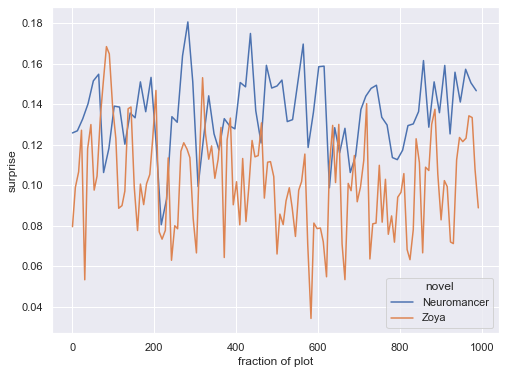

In [129]:
sns.set(rc={'figure.figsize':(8,6)})
sns.lineplot(data = plotdf, x = 'fraction of plot', y = 'surprise', hue = 'novel')
plt.show()

In [69]:
np.mean(auto_distance)

0.13660608675199518

In [70]:
np.mean(human_distance2)

0.12198432878891806

In [71]:
np.mean(human_distance)

0.1539047477086858

In [130]:
def divide_into_fifths(list_of_lists):
    # Initialize lists to hold the fifths
    fifths = [[] for _ in range(5)]

    for sublist in list_of_lists:
        # Determine the length of each fifth
        fifth_length = len(sublist) // 5

        # For each fifth
        for i in range(5):
            start_index = i * fifth_length
            # Adjust the end index for the last fifth to include any remaining elements
            end_index = (i + 1) * fifth_length if i < 4 else len(sublist)
            # Append the elements to the corresponding list
            fifths[i].extend(sublist[start_index:end_index])

    return fifths

fifths = divide_into_fifths([ambsame, jedisame, bsame, zsame, corpsame, ysame, oilsame, neurosame, clocksame])


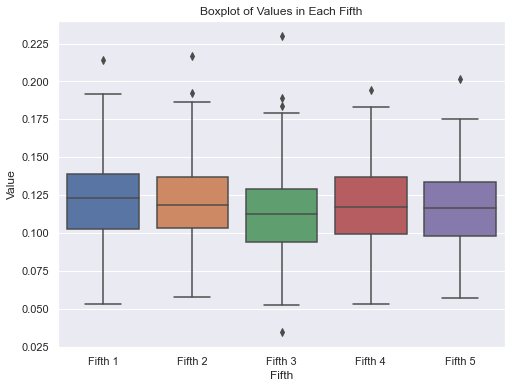

In [131]:
data = []
for i, fifth in enumerate(fifths):
    for value in fifth:
        data.append({'Fifth': f'Fifth {i+1}', 'Value': value})

df = pd.DataFrame(data)
sns.boxplot(x='Fifth', y='Value', data=df)
plt.title('Boxplot of Values in Each Fifth')
plt.show()

In [88]:
len(fifths[1])

95